# Set up analysis environment

In [1]:
using Pkg
Pkg.activate("..");

 Activating environment at `~/code/algorithmwatch-instagram/Project.toml`


In [2]:
Pkg.instantiate()
using CSV, JSON
using DataFrames
using Dates, CategoricalArrays
using Statistics, GLM
using VegaLite

# Load posts and donations
Towards a Monitoring of Instagram (TAMI) is a controlled experiment that aims at shedding light on how items are prioritized by Instagram’s newsfeed algorithm, focusing on political parties in the Netherlands. Posts of Dutch politicians (all members of parliament and the top politician of each party) and political parties were monitored. A set of donors was recruited. Donors share their Instagram feed at hourly intervals. **We are interested in understanding what posts of the politians are encountered by the donors in their feed.**  

We organize the analysis around potential encounters of posts of monitored politicians by donors at hourly intervals. Only the first 7 days after post creation are considered. For each of potential encounter, we store the following dynamic properties at hourly intervals: the number of likes, the number of comments, and the presence of an encounter. We use information from posts to model the probability of an encounter given a certain post. To this end, we prepare a representation of posts with  static properties that can explain the probability of an encounter. It is based on results from the Google Vision API (safe search, label annotations), hashtags from the post text, and the number of followers of the politician’s account.

### Data last updated Feb 8

## Posts

In [3]:
posts = CSV.File("../data/posts_with_topics.csv", dateformat="yyyy-mm-dd HH:MM:SS") |> DataFrame;

print("Total posts in the sample (incl. video posts)")
length(unique(posts[!, :post_short_code]))

Total posts in the sample (incl. video posts)

8708

In [4]:
transform!(posts, :poster_username => categorical => :poster_username)
transform!(posts, [:image_adult, :image_medical, :image_racy, :image_spoof, :image_violence] .=> categorical);

For some posts we can't analyze the caption (i.e. it is empty), and sometimes we cannot analyze the image tags (e.g. for videos). These are removed from the analysis:

In [5]:
@show count(ismissing.(posts.ig_media_caption));

transform!(posts, :image_labels => ByRow(x -> length(JSON.parse(x))) => :num_image_labels);
@show count(posts.num_image_labels .== 0);

dropmissing!(posts);
posts = posts[posts.post_created .>= DateTime(2020, 1, 1),:];

print("Total posts in the sample (excl. video posts)")
length(unique(posts[!, :post_short_code]))

count(ismissing.(posts.ig_media_caption)) = 209
count(posts.num_image_labels .== 0) = 1742
Total posts in the sample (excl. video posts)

6785

Now we show the number of posts created by the politicians over time. There could be a ramp-up towards the elections, but many elements need to be considered. In particular: 
- we added new accounts of politicians in November 2020
- our scraper might have missed some posts (might be the cause of the October drop)
- some politicians switched their profiles to "private" over the course of the experiment.

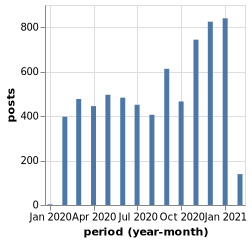

In [6]:
period_posts = combine(
    groupby(transform(unique(posts[!, [:post_short_code, :post_created]]), :post_created => ByRow(t -> round(t, Dates.Day)) => :period), [:period]),
    nrow => :num_posts)

period_posts |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonth"}, 
    y={"sum(num_posts)", axis={title="posts"}},
)

## Topics

In order to find out whether Instagram's algorithm favored some content over the rest, we divided the posts into topics.

**Topics are defined automatically and change with new data**. We use a latent Dirichlet allocation (LDA) to divide the posts into topics. LDA is a commonly-used algorithm that detects topics in documents based on the distribution of words, and allocates a "topic score" to each, so that a document does not have to be linked to just one topic (e.g. a post showing a face and a cat could be classified as 50% topic "faces" and 50% topic "pets").

We divide all posts into twice 8 topics (the number 8 was chosen arbitrarily), first by caption, then by image labels.

### Caption topics

The words in the topics were organized into eight topics. A label was constructed for each topic by interpreting the top words in each topic. Here are posts that score high on an individual caption topic:

In [7]:
gdf = groupby(stack(posts, names(posts, r"cap_top\d+")), :variable);

Based on these posts, and the top words in `topics_caption.csv` the following interpretion was made. In the figure that show the proportion of the topics over time, we can see that the election topics grows in the lasts months:

In [8]:
topics_caption = CSV.File("../data/topics_caption.csv")|> DataFrame
first(topics_caption,10)

,top1,top2,top3,top4,top5,top6,top7,top8
,String,String,String,String,String,String,String,String
1,zee,nederland,via,kunnen,nederland,mijn,and,kamer
2,even,tegen,bio,meer,verkiezingen,jaar,of,tweedekamer
3,wandelen,meer,link,mensen,politiek,ze,to,tweede
4,weer,mensen,mijn,zorg,tk,nog,i,debat
5,dag,fvd,ons,of,groenlinks,veel,for,samen
6,strand,nu,of,worden,tweede,was,this,week
7,duik,geen,gesprek,ons,ons,weer,you,prinsjesdag
8,mooi,nog,uur,hebben,tweedekamer,mensen,amsterdam,corona
9,mooie,door,nieuwe,kan,stem,dan,love,werkbezoek


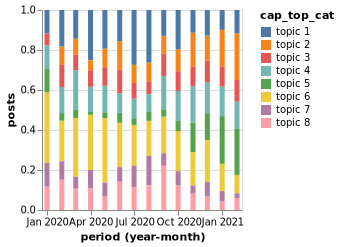

In [9]:
posts.cap_top_cat = recode(string.(posts.cap_top_cat),
    "1" => "topic 1",
    "2" => "topic 2",
    "3" => "topic 3",
    "4" => "topic 4",
    "5" => "topic 5",
    "6" => "topic 6",
    "7" => "topic 7",
    "8" => "topic 8",
);

period_caption = combine(
    groupby(transform(posts, :post_created => ByRow(yearmonth) => :period), [:period, :cap_top_cat]),
    nrow => :count)

period_caption |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonth"}, 
    y={"count", axis={title="posts"}, stack=:normalize},
    color={"cap_top_cat:n"})

### Image topics
Images were analyzed with the Google Vision API, and the resulting image tags were organized into eight topics. The post the highest score per topic are listed below:

In [10]:
gdf = groupby(stack(posts, names(posts, r"im_top\d+")), :variable);
#select(
#    combine(df -> first(sort(df, :value, rev=true), 3), gdf),
#    :im_top_cat, :post_short_code => ByRow(x -> string("http://instagram.com/p/", x)))

Based on these posts, and the top labels in `topics_image.csv` the following interpretation of the image topics was made. Some categories are not very clear and some concepts (such as electronics) can easily move from one topic to another when we re-run the LDA topic modelling.

In [11]:
topics_image = CSV.File("../data/topics_image.csv")|> DataFrame
first(topics_image,10)

,top1,top2,top3,top4,top5,top6,top7,top8
,String,String,String,String,String,String,String,String
1,architecture,plant,event,sky,font,technology,event,forehead
2,building,flower,white-collar worker,tree,text,electronic device,photography,face
3,interior design,tree,suit,cloud,line,outerwear,fun,smile
4,room,art,job,natural landscape,advertising,footwear,people,head
5,furniture,flowering plant,businessperson,grass,brand,sleeve,tourism,chin
6,table,botany,formal wear,natural environment,screenshot,street fashion,team,hair
7,city,holiday,employment,water,poster,jacket,food,nose
8,sky,grass,public speaking,plant,photo caption,display device,vacation,photography
9,house,spring,spokesperson,nature,graphics,clothing,community,facial expression


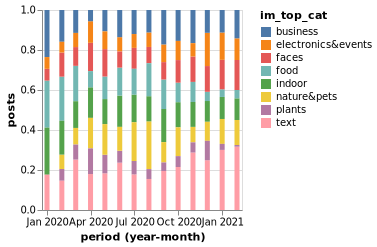

In [12]:
posts.im_top_cat = recode(string.(posts.im_top_cat), 
    "1" => "indoor",
    "2" => "plants",
    "3" => "business",
    "4" => "nature&pets",
    "5" => "text",
    "6" => "electronics&events",
    "7" => "food",
    "8" => "faces",
);

period_image = combine(
    groupby(transform(posts, :post_created => ByRow(yearmonth) => :period), [:period, :im_top_cat]),
    nrow => :count)

period_image |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonth"}, 
    y={"count", axis={title="posts"}, stack=:normalize},
    color={"im_top_cat:n"})

## Donations

Next we load the donations, and display the number of donations over time. The number of donations varied wildly, with a peak in November when the call-to-action was issued.

In [13]:
donations = CSV.File("../data/donations.csv", dateformat="yyyy-mm-dd HH:MM:SS") |> DataFrame;

donations.post_DOW = categorical(map(Dates.dayname, donations.post_created), levels=Dates.dayname.(1:7));
donations.post_HOD = categorical(map(x -> Dates.value(Dates.Hour(x)), donations.post_created));
donations.post_age = (donations.donation_created - donations.post_created) / convert(Dates.Millisecond, Dates.Hour(1));

donations.likes_cat = cut(donations.likes_count, [0, 5, 10, 100, 1000], extend=true);
donations.comments_cat = cut(donations.comments_count, 5);
donations.post_age_cat = cut(donations.post_age, [1, 3, 24], extend=true);

@show(nrow(donations))

nrow(donations) = 37419


37419

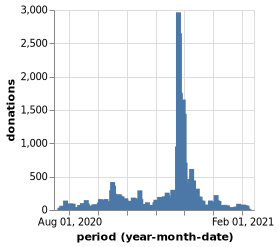

In [14]:
period_donations = combine(
    groupby(transform(donations, :post_created => ByRow(t -> round(t, Dates.Day)) => :period), :period),
    nrow => :num_donations)

period_donations |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonthdate"}, 
    y={"sum(num_donations)", axis={title="donations"}},
)

In [15]:
df = innerjoin(select(donations, Not(:post_created)), posts, on=:post_id);

## RQ1: What posts are overrepresented in the encounters?

To answer this question, we need to describe what posts of Dutch politicians on Instagram are overrepresented in general. This might be due to popularity of the post, or due to biases in Instagram’s recommendations. We are interested in topics, derived from words in the caption and from Google Vision API labels for the post’s images.

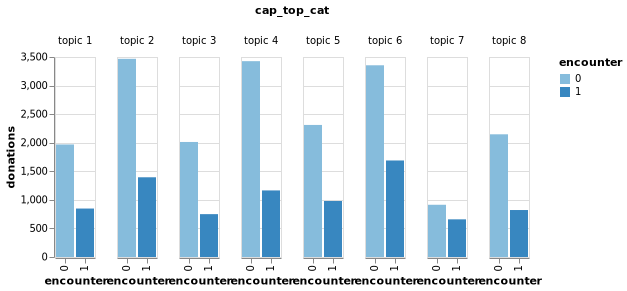

In [16]:
combine(groupby(df, [:cap_top_cat, :encounter]), nrow => :donations) |>
@vlplot(
    :bar,
    column = "cap_top_cat:o",
    color = "encounter:o",
    x = "encounter:o",
    y = "donations"
)

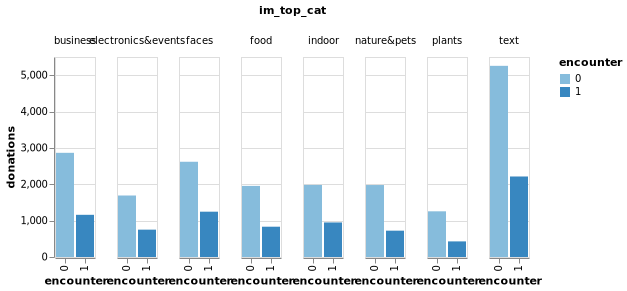

In [17]:
combine(groupby(df, [:im_top_cat, :encounter]), nrow => :donations) |>
@vlplot(
    :bar,
    column = "im_top_cat:o",
    color = "encounter:o",
    x = "encounter:o",
    y = :donations
)

## RQ2: What posts are overrepresented given their popularity? 
Since overrepresentation is likely to driven by popularity, we analyse what types of posts are overrepresented if we **correct for effects of post popularity** and the timing of a post (time of the day and day of the week). Remaining variations in post popularity can indicate biases in Instagram’s recommendations. The biases might be limited to the population of donors.

In [18]:
baseline_formula = @formula(encounter ~ 1 
    + log1p(post_age) + log1p(likes_count) + log1p(comments_count) + log1p(follows)
    + post_age_cat + likes_cat + comments_cat
    + post_DOW + post_HOD
    );
baseline_model = glm(baseline_formula, df, Binomial(), LogitLink());
df.pred_popularity = predict(baseline_model, df);

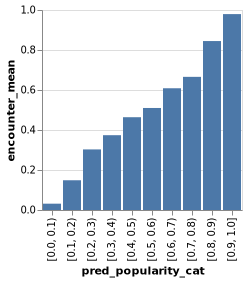

In [19]:
df.pred_popularity_cat = cut(df.pred_popularity, 0:.1:1, extend=true);
combine(groupby(df, :pred_popularity_cat), :encounter=>mean) |> 
    @vlplot(:bar, x="pred_popularity_cat:o", y=:encounter_mean)

This figure shows the encounter frequency is well predicted with the logisitic regression model for popularity. Thus, a large part of the observed encounters can be explained by the presence of competing posts (i.e. time of day or day of week effects), and by the popularity of a post in relation to its age (through post age, likes and comments). We use this model as a popularity factor, to analyse how much properties of the post content *additionally* changes the probability of encountering a post.

In [20]:
odds(p) = p / (1-p);
logit(p) = log(odds(p));

f2 = @formula(
    encounter ~ 1
        + logit(pred_popularity) # Here we re-use the prediction from the popularity model.
        + (im_top2 + im_top3 + im_top4 + im_top5 + im_top6 + im_top7 + im_top8)
        + (cap_top2 + cap_top3 + cap_top4 + cap_top5 + cap_top6 + cap_top7 + cap_top8)
        + image_adult_categorical + image_medical_categorical + image_racy_categorical + image_spoof_categorical + image_violence_categorical
    );

m2 = glm(f2, df, Binomial(), LogitLink());
df.prediction_RQ2 = predict(m2, df);

Now we can compare the predictions of the baseline popularity model, and the model that uses topic information in addition to the popularity factors. Differences between the predictions are due to topics. If a topic results in an increased chance of an encouter, we call this a positive bias. To compute the bias, we convert the predictions of both models to log-odds using the logit transform, and compute the difference.

In [21]:
df.bias = logit.(df.prediction_RQ2) - logit.(df.pred_popularity);

Now we can analyze the bias per caption topic.

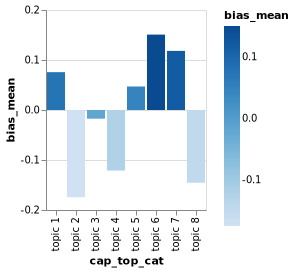

In [22]:
combine(groupby(df, :cap_top_cat), :bias=>mean) |> 
    @vlplot(:bar, x="cap_top_cat:o", y=:bias_mean, color=:bias_mean)

Images with the topics `faces` are more likely to reach the donor's feed, while `text` are less likely to reach the donor's feed.

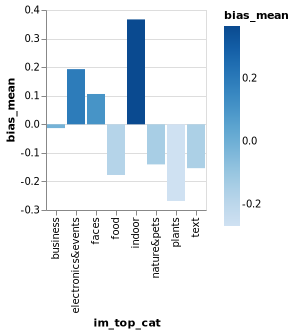

In [23]:
combine(groupby(df, :im_top_cat), :bias=>mean) |> 
    @vlplot(:bar, x="im_top_cat:o", y=:bias_mean, color=:bias_mean)

 Note that this bias might not generalize to other content creators than Dutch politicians, and might not generalize to other users than the donors that participated in this experiment.

## RQ3: Is the overrepresentation the same in all subgroups? 

Do the results hold robustly in sub groups? If so, they are more likely to generalize to a wider population. Here we split the data in months, and analyze if the bias is indeed higher for encountered posts than non-encountered posts in each month.

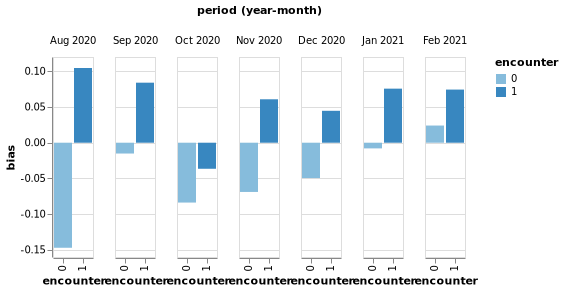

In [24]:
period_bias = combine(
    groupby(transform(df, :post_created => ByRow(t -> round(t, Dates.Month)) => :period), [:period, :encounter]),
    :bias => mean)

period_bias |> @vlplot(:bar, 
    column={"period:o", timeUnit="yearmonth"}, 
    x = "encounter:o",
    y = {"bias_mean", axis={title="bias"}},
    color = "encounter:o",
)

Within each month, a lower bias is observed for non-encounters than encounters. Thus the bias is robust over different months. Note though that the bias varies strongly from month to month. Since the bias is a function of caption and image topics, this suggests that the *content* has changed from month to month.

## RQ4: Who benefit from these discrepancies? 

Finally, we can estimate per politician how much their posts were benefitting from a consistent algorithm bias of Instagram’s recommendations. Note that this bias can be caused by personalisation; if the donors are of a particular political affiliation they might be presented more with content in line with their views.

In [25]:
parties = CSV.File("../data/parties.csv") |> DataFrame;
rename!(parties, Symbol("IG username") => :ig_username, Symbol("Full name") => :name);
parties = dropmissing(parties[!,[:party, :ig_username, :name]]);
parties.ig_username = categorical(parties.ig_username);
parties.party = categorical(parties.party);

In [26]:
post_bias = combine(groupby(df, [:post_id, :poster_username]), :bias => mean => :bias)
post_bias = innerjoin(post_bias, parties, on=:poster_username => :ig_username)

poster_bias = combine(groupby(post_bias, [:poster_username, :party]), 
    nrow => :num_encounterable_posts, 
    :bias .=> mean)

poster_bias.benefit = poster_bias.bias_mean;
poster_bias = sort(poster_bias, :benefit, rev=true)
first(poster_bias[poster_bias.num_encounterable_posts .> 5,:], 5)

,poster_username,party,num_encounterable_posts,bias_mean,benefit
,Cat…,Cat…,Int64,Float64,Float64
1,klaasdijkhoff,VVD,7,0.326144,0.326144
2,thierryaartsen,VVD,11,0.272316,0.272316
3,lianedenhaan,50PLUS,26,0.27019,0.27019
4,koerhuisdaniel,VVD,9,0.192391,0.192391
5,michelrogcda,CDA,18,0.179815,0.179815


# Appendix

#### Image topic 1

![](topic1.jpg)

#### Image topic 2

![](topic2.jpg)

#### Image topic 3

![](topic3.jpg)

#### Image topic 4

![](topic4.jpg)

#### Image topic 5

![](topic5.jpg)

#### Image topic 6

![](topic6.jpg)

#### Image topic 7

![](topic7.jpg)

#### Image topic 8

![](topic8.jpg)

#### Caption topic 1

In [27]:
first(select(unique(sort(posts, :cap_top1, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

,poster_username,ig_media_caption
,Cat…,String
1,lodewijkasscher,ANDERHALF METER !
2,thierry_baudet,Lente. Thuis.
3,thierry_baudet,Prachtfoto!\n\nCredits: @lonneke_stulen.
4,salimabelhaj,Even vakantie #fuerteventura. De zandstorm #calima overleefd.
5,jobavandenberg,Wat een geduld! Broedende zwaan 🦢
6,jobavandenberg,Even buiten bewegen: wandelen 🥾rond #’sHeerHendrikskinderen
7,klaasdijkhoff,#Applausvoordezorg 👏🏼
8,remcovvd,Hollandse luchten tijdens #klompenpad tussen #Rhenen en #Wageningen #sky
9,remcovvd,Rondje Batouwse klompenpad #walking #betuwe @lienden #lienden


#### Caption topic 3

In [28]:
first(select(unique(sort(posts, :cap_top3, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

,poster_username,ig_media_caption
,Cat…,String
1,lodewijkasscher,Het is @hziyech van harte gegund en @chelseafc is een mooie club maar oh oh oh wat had ik hem graag nog vele seizoenen bij Ajax bewonderd...
2,thierry_baudet,BINNENKORT!
3,thierry_baudet,BOEKEN SIGNEREN! Het is weer maandag...😎 Bestel óók een van de exclusieve #FVD-titels via onze webshop! Ga naar https://shop.fvd.nl!
4,eppobruins,Sleepy
5,haykeveldman,#denhaagvandaag
6,pieter.heerma,🥋💪 #fyi #teamCDA
7,martijnvanhelvert,Voor link: Zie bio☝🏼
8,thechangeagent,"Over vasten, #Ramadanseries en de nieuwe maan: lees m'n nieuwste blog! Link in bio. 🌙\n\n#ramadan2020 #Eidmubarak"
9,johnwmkerstens,Stukken lezen. Ook.


#### Caption topic 4

In [29]:
first(select(unique(sort(posts, :cap_top4, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

,poster_username,ig_media_caption
,Cat…,String
1,thierry_baudet,"Corona. In deze mini-documentaire laten we zien hoe het zo ver heeft kunnen komen. Wat de voorgeschiedenis is, hoe we hier terecht zijn gekomen. En hoe we hier weer uit komen. Op gecontroleerde wijze. Omdat we zowel maximaal levens willen beschermen, als de economie en samenleving weer op gang moeten krijgen! Link in bio!"
2,klaasdijkhoff,Hallmark speelt open kaart...
3,verabergkamp,Wordt wel lang 💇\u200d♀️;).
4,jaco_geurts,#coronavirusnl
5,martijnvanhelvert,Zojuist heeft het #CDA een motie ingediend die het kabinet opdraagt om tot een oplossing te komen voor #grensondernemers die tussen de wal en het schip geraken bij #coronamaatregelen\nWe rekenen op brede steun!\n#KortelijnmetMartijn
6,martijnvanhelvert,Heb het #kabinet gevraagd of NL zich aansluit bij het initiatief van de #G20 om geld te geven aan instituten die een #vaccin tegen #covid_19 kunnen uitvinden. Alleen met een snel vaccin kunnen we niet alleen in eigen land maar ook op #Griekse Eilanden of in #Afrika een grote ramp voorkomen.\n#corona #KortelijnmetMartijn
7,maarten_hijink,De zorg verdient meer dan alleen een applaus!
8,maarten_hijink,Geef ouderen keuze: goede zorg thuis óf een plek in het Zorgbuurthuis
9,thechangeagent,"Onacceptabel: lerarentekort Rotterdam blijkt nog veel groter dan gedacht, en treft vooral de meest kwetsbare kinderen.\nDaarom net deze Kamervragen ingediend. Ieder kind verdient een eerlijke start!"


#### Caption topic 5

In [30]:
first(select(unique(sort(posts, :cap_top5, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

,poster_username,ig_media_caption
,Cat…,String
1,lodewijkasscher,Almere uit...
2,thierry_baudet,Mooie stap voor de partij! En een reuzensprong voor Nederland! #FVD
3,geertwilders,Goedemorgen Nederland!
4,rudmerheerema,Ice cream monster.
5,rudmerheerema,5yo #artlover
6,thechangeagent,#Eidmubarak 🌙🙏🏼❤
7,johnwmkerstens,Den Haag vandaag.
8,johnwmkerstens,Post van een kiezer.
9,johnwmkerstens,Gymles.


#### Caption topic 6

In [31]:
first(select(unique(sort(posts, :cap_top6, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

,poster_username,ig_media_caption
,Cat…,String
1,thierryaartsen,"Carnaval 2020, wat was je weer mooi. Heerlijk kunnen genieten van het mooiste volksfeest van het jaar. Hoe vaak moeten we de kliko nog buiten zetten voor we weer mogen? #carnaval #kielegat #breda"
2,mustafaamhaouch,🏃🏽\u200d♂️🇲🇦 #sportyspice
3,lodewijkasscher,"Vandaag herdenken we. Ik denk aan dit vrolijke baby’tje: het kind dat gered werd. Ik denk aan de mensen die hem redden. De moed die zij hadden, de onbeschrijflijke moed. De veiligste plek om hem te verstoppen was als hun kind, hun zoon. In hun gezin. Ik denk aan het verdriet - toen en erna. En ben dankbaar. Omdat dit kind gered werd, leven wij nu nog. Preciezer, leef ik nu."
4,lodewijkasscher,Weekend. Geluk
5,lodewijkasscher,@kinderburgemeester.ilias interviewde me tijdens de #onderwijsstaking- een grote eer voor mij
6,thierry_baudet,Even iets leuks. Dit is de zomer: ijsje met meisje. Als deze #coronacrisis voorbij is gaan we de straat weer op en het leven vieren! Deel allemaal een paar foto’s van fijne momenten het afgelopen jaar! Er is écht licht aan het einde van de tunnel. Sterkte & liefs aan allen! En HEEL ERG VEEL DANK aan onze #zorghelden!
7,thierry_baudet,Even iets moois. En een hele fijne dag allemaal! ❤️@davidegallery
8,jobavandenberg,In herinnering mijn ouders die deze week 65 jaar getrouwd zouden zijn geweest.
9,adiertens,Ik ben stil om te gedenken. Ook denk ik aan mijn oom Geert Jan Diertens die gefusilleerd is. En aan allen die in het verzet zaten. \n#trimunt #westerkwartier #4mei


#### Caption topic 7

In [32]:
first(select(unique(sort(posts, :cap_top7, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

,poster_username,ig_media_caption
,Cat…,String
1,thierry_baudet,"The last supper. Scrovegni Chapel, Padua (Giotto). I’ll never forget when I visited this sacred place with my father. So beautiful. Blessed easter to all of you!"
2,thierry_baudet,Mr. Hiddema met zijn belangrijkste adviseur. Happy birthday!
3,thierry_baudet,#friends #love
4,remcovvd,How to make your puber #child #happy? #sushi #cooking #sushitime #food #foodporn 🍴 🍤🥗 🍣
5,remcovvd,#usa #oneworldtradecenter #wtc #911memorial 🇺🇸🙏🏻💪🏼
6,remcovvd,How beautiful? #flying #blue #skies #freedom #newyork
7,remcovvd,Packing my #suitcase #newyork
8,niels_vdberge,"Dear friends from Bangladesh, India, Myanmar, Sri Lanka and Cambodia. Happy New Year!\n\nIt’s hard to imagine this day without the parade, large gatherings with family and friends and roads full of people.\n\nDespite these exceptional circumstances, I wish you all a joyful day and a healthy, happy and prosperous year. Let’s hope we will be able to meet soon again ❤️ 💚 [This photos was taken in 2016, @Dhaka, Bangladesh]"
9,eppobruins,Staverdens beekdal #nofilter #hemelvaartsdag


#### Caption topic 8

In [33]:
first(select(unique(sort(posts, :cap_top8, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

,poster_username,ig_media_caption
,Cat…,String
1,jobavandenberg,Gisteren bij #BNR in #Amsterdam over het #Coronavirus Vandaag in de gele bus 🚌 van #NTR1 in @gemeenteterneuzen samen met #EllendeFeijter @cdazeeland
2,remcovvd,#fotodrent #foto
3,remcovvd,Op bezoek bij de @unitednations @newyork
4,remcovvd,"Woningbouw op de #Binkhorst op de grens van Den Haag, Voorburg en Rijswijk. Kijkje nemen"
5,tjeerdvand66,"Gister, in een lege gang van de zo goed als lege D66 vleugel in de Tweede Kamer, werd ik geïnterviewd door Omroep Human over de toekomst van de landbouw. Natuurlijk ook op anderhalve meter afstand."
6,haykeveldman,Den Haag vandaag
7,haykeveldman,#oudezaaltweedekamer #rondetafelgesprek #coronaapp
8,haykeveldman,Deze week in de kamer: #technischebriefing en #rondetafelgesprek #coronaapp #coronavirus en #debat
9,haykeveldman,#coronavirus #blijfthuisindienmogelijk #doenwatnodigis


#### Caption topic 1

In [34]:
first(select(unique(sort(posts, :cap_top1, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

,poster_username,ig_media_caption
,Cat…,String
1,lodewijkasscher,ANDERHALF METER !
2,thierry_baudet,Lente. Thuis.
3,thierry_baudet,Prachtfoto!\n\nCredits: @lonneke_stulen.
4,salimabelhaj,Even vakantie #fuerteventura. De zandstorm #calima overleefd.
5,jobavandenberg,Wat een geduld! Broedende zwaan 🦢
6,jobavandenberg,Even buiten bewegen: wandelen 🥾rond #’sHeerHendrikskinderen
7,klaasdijkhoff,#Applausvoordezorg 👏🏼
8,remcovvd,Hollandse luchten tijdens #klompenpad tussen #Rhenen en #Wageningen #sky
9,remcovvd,Rondje Batouwse klompenpad #walking #betuwe @lienden #lienden


In [35]:
m2

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

encounter ~ 1 + :(logit(pred_popularity)) + im_top2 + im_top3 + im_top4 + im_top5 + im_top6 + im_top7 + im_top8 + cap_top2 + cap_top3 + cap_top4 + cap_top5 + cap_top6 + cap_top7 + cap_top8 + image_adult_categorical + image_medical_categorical + image_racy_categorical + image_spoof_categorical + image_violence_categorical

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────
                                     Coef.  Std. Error      z  Pr(>|z|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                     0.848168     0.101784    8.33    <1e-16    0.648674    1.04766
logit(pred_popularity)          1.01351      0.0131338  77.17  

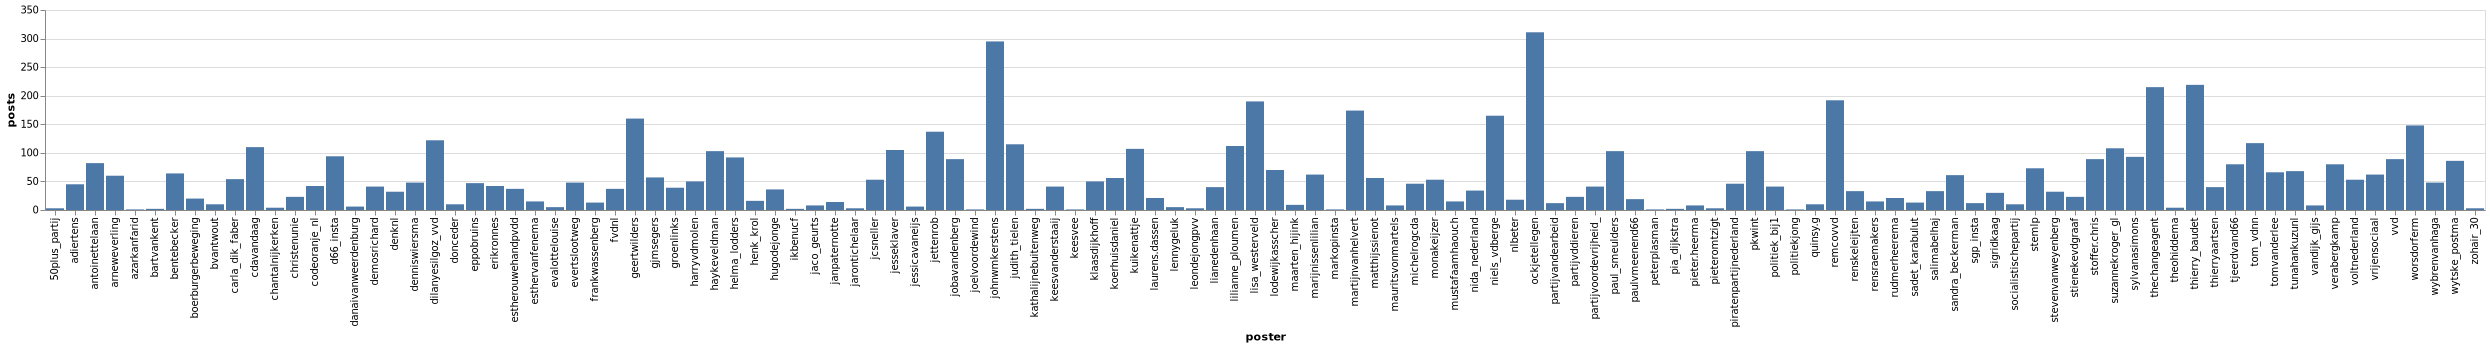

In [36]:
period_posts = combine(
    groupby(transform(posts, :post_created => ByRow(t -> round(t, Dates.Day)) => :period), [:poster_username, :period]),
    nrow => :num_posts)

sort!(period_posts, [:poster_username])

period_posts |> @vlplot(
    :bar,
    x={"poster_username:o", sort="x", axis={title="poster"}},
    y={"sum(num_posts)", axis={title="posts"}}
)